## Strong Lensing Time Delay metric

This metric is used to estimate the number of strongly lensed supernovae


## Imports

In [1]:
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.db as db
import lsst.sims.maf.utils as utils
import sqlite3
import numpy as np
from lsst.sims.maf.metrics.snSLMetric import SNSLMetric
import lsst.sims.maf.metrics as metrics

## DB file choice

In [2]:
# Database available from https://lsst-web.ncsa.illinois.edu/sim-data/sims_featureScheduler_runs1.4/baseline/
dbFile = 'baseline_v1.4_10yrs.db' #'descddf_v1.4_10yrs.db'
dbName = 'baseline_v1.4_10yrs.db'
opsimdb = db.OpsimDatabase(dbFile)

## Define slicer

In [3]:
slicer = slicers.HealpixSlicer(nside=64)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


## Make the bundles

### Run for selected years

In [4]:
bundleList= []

metric = SNSLMetric(night_collapse=True)
summaryStats = [metrics.SumMetric()]            
sql = '' #'night < 730'

bundleList.append(metricBundles.MetricBundle(
    metric, slicer, sql, runName= dbName,summaryMetrics=summaryStats))
print(len(bundleList))

1


In [5]:
%%time
outDir = '{}_SLTimeDelay'.format(dbName)
resultsDb = db.ResultsDb(outDir=outDir)
bundleDict = metricBundles.makeBundlesDictFromList(bundleList)
bgroup = metricBundles.MetricBundleGroup(bundleDict, opsimdb, outDir=outDir, resultsDb=resultsDb)
bgroup.runAll()

Querying database SummaryAllProps with no constraint for columns ['numExposures', 'observationStartMJD', 'night', 'fieldRA', 'fiveSigmaDepth', 'observationId', 'visitTime', 'fieldDec', 'filter', 'visitExposureTime'].
Found 2180589 visits
Running:  ['baseline_v1_4_10yrs_db_SNSLMetric_HEAL']


/Users/yoachim/git_repos/sims_maf/python/lsst/sims/maf/slicers/baseSpatialSlicer.py:110: UserWarning: Warning:  Loading maps but cache on.Should probably set useCache=False in slicer.
  warnings.warn('Warning:  Loading maps but cache on.'
/Users/yoachim/git_repos/sims_maf/python/lsst/sims/maf/maps/dustMap.py:24: UserWarning: Slicer value of nside (64) different from map value (128), using slicer value
  warnings.warn('Slicer value of nside (%i) different from map value (%i), using slicer value'


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
CPU times: user 24min 51s, sys: 27.4 s, total: 25min 18s
Wall time: 28min 48s


Plotting figures with "" constraint now.


/Users/yoachim/lsst/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.4.1/lib/python3.8/site-packages/healpy/projaxes.py:202: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  aximg = self.imshow(
/Users/yoachim/git_repos/sims_maf/python/lsst/sims/maf/plots/plotHandler.py:569: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figformat" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig(os.path.join(self.outDir, plotFile), figformat=self.figformat, dpi=self.dpi,
/Users/yoachim/git_repos/sims_maf/python/lsst/sims/maf/plots/plotHandler.py:569: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figformat" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig(os.path.join(self.out

Plotting complete.


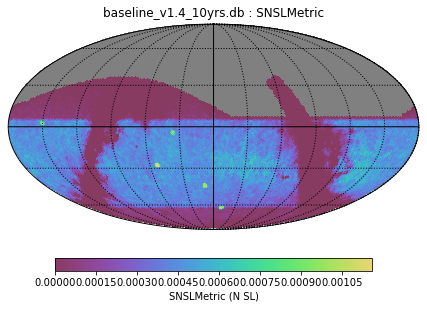

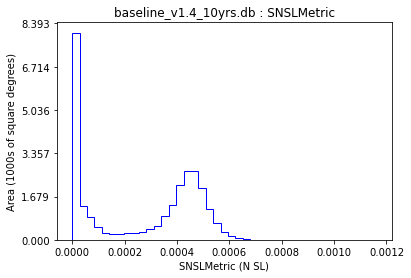

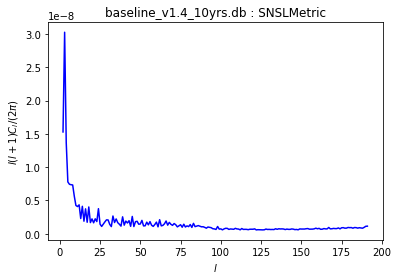

In [6]:
bgroup.plotAll(closefigs=False)

/Users/yoachim/lsst/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.4.1/lib/python3.8/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/Users/yoachim/lsst/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.4.1/lib/python3.8/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_under(bgcolor)
/Users/yoachim/lsst/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.4.1/lib/python3.8/site-packages/healpy/projaxes.py:9

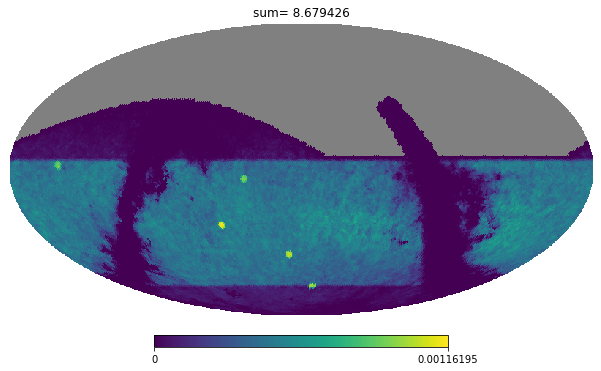

In [7]:
#Now just make the plot manually 
import healpy as hp
hp.mollview(bundleList[0].metricValues,  title='sum= %f' % bundleList[0].summaryValues['Sum'])